In [1]:
from google.colab import drive
from shutil import copyfile
import numpy as np
import pandas as pd
import zipfile
from time import time
from pathlib import Path
import os
import random
from skimage import io
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import shutil
import cv2 as cv
import imutils
# architecture and inference phase
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19,ResNet50,InceptionResNetV2
from keras.layers import Normalization, Dense
from tensorflow.keras.models import Model


# Brain Tumor Classification (MRI)

The images dataset, provided as a set of slices, from [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data), contains 3064 T1-weighted constrast-enhanced  MRI images. It's made up by four classes:

| Class          | Description                                                                                                 |
|----------------|-------------------------------------------------------------------------------------------------------------|
| GLIOMA TUMOR   | It's a type of tumor that starts in the glial cells of the brain or the spine. <br> Gliomas comprise about 30 percent of all brain tumors and central nervous system tumors, and 80 percent of all malignant brain tumors. |
|MALIGNANT TUMOR | it contrasts with a non-cancerous benign tumor in that a malignancy is not self-limited in its growth.<br> It's capable of invading into adjacent tissues, and may be capable of spreading to distant tissues|
|PITUARY TUMOR| It's a tumor that occur in the pituitary gland. Pituitary adenomas are generally divided into three categories <br> dependent upon their biological functioning: benign adenoma, invasive adenoma, and carcinomas|
|NO TUMOR | the Brain scan is normal. No Tumor is detected|

Brain Magnetic Resonance Imaging (MRI) image
is an essential tool for the detection of tumor progression
modeling processes



In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Preprocessing and Exploratory Data Analysis

We define the function 'import_and_extract_dataset' to transfer and extract the training and test datasets to the local colab virtual machine.  
We next use the extracted data to generate graphs showing the distribution of the number of files in each class for each path. Then some images of the training dataset are shown

In [3]:
def import_and_extract_dataset(source_path, destination_path):
    t0 = time()
    # Transfer zip dataset to the current virtual machine
    copyfile(source_path, destination_path)
    # Extract files
    with zipfile.ZipFile(destination_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("File transfer completed in %0.3f seconds" % (time() - t0))
    return destination_path

In [6]:
path_training = '/content/gdrive/MyDrive/digital signal and image management progetto/bi_dim_signal - Doghmi Samir/Testing.zip'
path_testing ='/content/gdrive/MyDrive/digital signal and image management progetto/bi_dim_signal - Doghmi Samir/Training.zip'
# Import and extract training dataset
base_path_training = import_and_extract_dataset(path_training, 'Training.zip')
print("Base path for training dataset:", base_path_training)

# Import and extract testing dataset
base_path_testing = import_and_extract_dataset(path_testing, 'Testing.zip')
print("Base path for testing dataset:", base_path_testing)
#mi estrae le due cartelle

File transfer completed in 5.909 seconds
Base path for training dataset: Training.zip
File transfer completed in 8.216 seconds
Base path for testing dataset: Testing.zip


In [7]:
def num_classes_plot(path, color, label):
    file_counts = {}

    for root, dirs, files in os.walk(path):
        for file in files:
            subdir_name = os.path.basename(root)
            file_counts[subdir_name] = file_counts.get(subdir_name, 0) + 1

    labels = list(file_counts.keys())
    counts = list(file_counts.values())

    # Creazione del grafico a barre con il colore specificato
    bar_trace = go.Bar(x=labels, y=counts, marker_color=color, name=label)
    return bar_trace

fig = go.Figure()

fig.add_trace(num_classes_plot('/content/Training', '#1f77b4', 'Training'))  # Colore blu per il training
fig.add_trace(num_classes_plot('/content/Testing', '#ff7f0e', 'Testing'))   # Colore arancione per il testing

fig.update_layout(showlegend=True, autosize=False, width=1000, height=450, title_text="Training vs Testing")
fig.show()

The split of the dataset:
* Glioma: Training - 826 images, Testing - 199 images
* No tumor: Training - 395 images, Testing - 105 images
* Pituitary tumor: Training - 827 images, Testing - 74 images
* Meningioma: Training - 822 images, Testing - 115 images

In [8]:
def extract_images(folder):
    subfolders = os.listdir(folder)
    paths = []

    # Iterate through subfolders and images
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        for image in sorted(os.listdir(subfolder_path)):
            if image.endswith('.jpg'):
                cur_path = os.path.join(subfolder_path, image)
                paths.append((cur_path, subfolder))  # Appending tuple of (image path, label)
    return paths

In [9]:
def display_images(paths):
    random.shuffle(paths)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, (image_path, label) in enumerate(paths[:8]):
        img = io.imread(image_path)
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img)
        axes[row, col].set_title(label)
        axes[row, col].axis('off')

    plt.show()

In [10]:
training_folder = "/content/Training"
testing_folder = "/content/Testing"

training = extract_images(training_folder)
testing = extract_images(testing_folder)

print(f'size:{len(training)}')
print(f'size:{len(testing)}')

size:2870
size:394


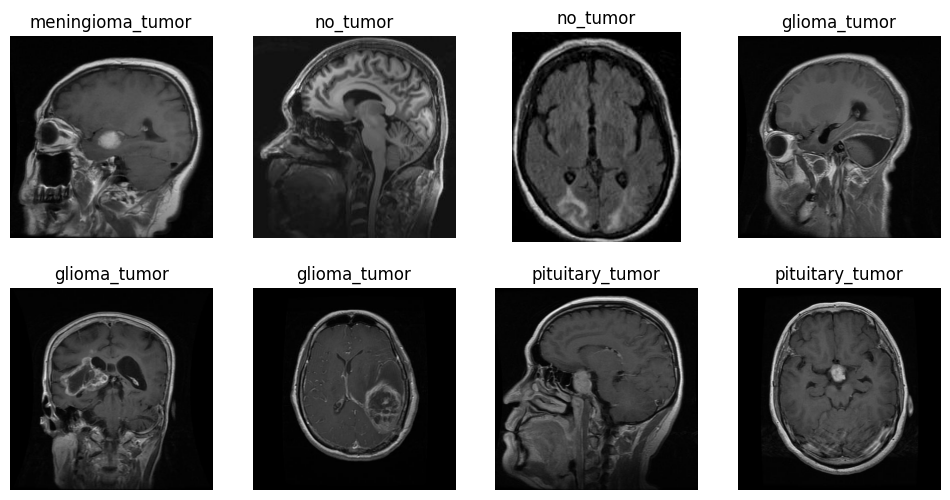

In [ ]:
display_images(training)

## Image Preprocessing

Image preprocessing guarantees that the images match the model’s expected input format.

- Converting the image to a single channel grayscale image. It makes things easy for the contour-detection algorithm
- Use the findContours() function to detect the contours in the image
- Draw Contours on a copy of the original RGB Image
- Find bounding rectangle for the outermost contour
- Draw the bounding rectangle on the image with contours
- Crop the image using the detected contours areas

In [11]:
def ignore_files(dir, files):
  return files  # Questa funzione ignora tutti i file

def crop_brain_contour(img_path):
          foto = cv.imread(img_path)
    # Convert the image to grayscale
          gray = cv.cvtColor(foto, cv.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
          gray = cv.GaussianBlur(gray, (5, 5), 0)
    # Apply binary thresholding to segment the brain region
          thresh = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]
          thresh = cv.erode(thresh, None, iterations=2)
          thresh = cv.dilate(thresh, None, iterations=2)
    # Find contours in the thresholded image
          cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
          cnts = imutils.grab_contours(cnts)
    # Select the largest contour
          c = max(cnts, key=cv.contourArea)
    # Find extreme points of the largest contour
          extLeft = tuple(c[c[:, :, 0].argmin()][0]) #left
          extRight = tuple(c[c[:, :, 0].argmax()][0])
          extTop = tuple(c[c[:, :, 1].argmin()][0])
          extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the brain region from the original image using extreme points
          new_image = foto[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

          return new_image

In [12]:
crop_training_path = "/content/training_crop"
crop_testing_path = "/content/testing_crop"

def apply_crop(path, crop_path):
    # Iterate over all items in the training directory
    for subfolder in os.listdir(path):
        s = os.path.join(path, subfolder)  # Source path
        d = os.path.join(crop_path, subfolder)  # Destination path

        # If the item is a directory, copy its structure to the destination folder
        if os.path.isdir(s):
            shutil.copytree(s, d, ignore=ignore_files)

        # Iterate over all files (images) within the subdirectory
        for img_name in os.listdir(s):
            img_path = os.path.join(s, img_name)  # Image path

            # Process the image, crop, and save to the destination folder
            cropped_image = crop_brain_contour(img_path)
            dest_image_path = os.path.join(d, img_name)  # Destination image path
            cv.imwrite(dest_image_path, cropped_image)  # Save the cropped image to the destination folder

apply_crop(training_folder, crop_training_path)
apply_crop(testing_folder, crop_testing_path)

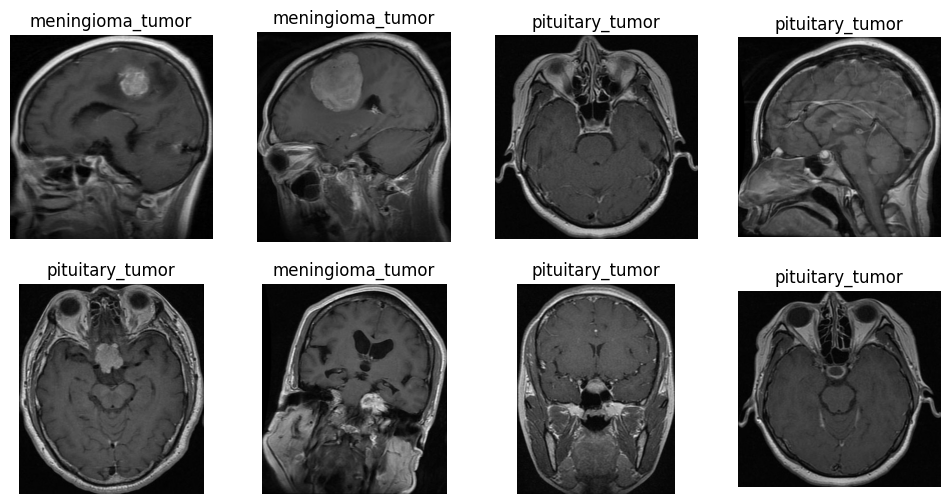

In [ ]:
training_crop_folder = extract_images(crop_training_path)
display_images(training_crop_folder)

## Image Augmentation


Image augmentation alters images in a way that can help prevent overfitting and increase the robustness of the model.

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
   preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

Example of image augmentation

In [ ]:
image_path= '/content/training_crop/glioma_tumor/gg (104).jpg'
image = plt.imread(image_path)
image = np.expand_dims(image, axis=0)


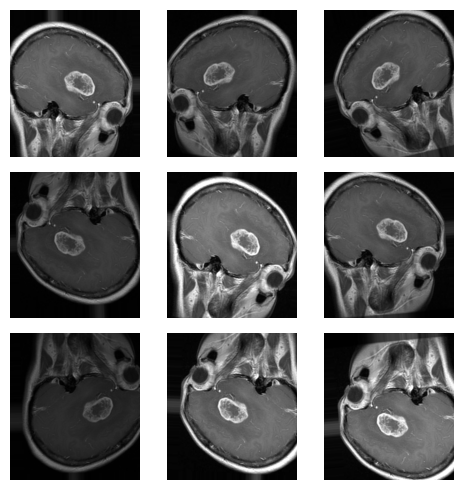

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(9):

    augmented_images = train_datagen.flow(image)
    augmented_image = augmented_images.next()[0]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Model from the scratch

The generated model includes  4 convolutional layers, 2 max-pooling layers and 2 dense layer with a total of 2,082,180 parameters. To mitigate overfitting, we introduce L2. regularization, dropout layers and a learning rate of 5e-5 during optimization. Also the model will be stopped if the val_loss remains stable for 5 epochs (patience= 5)

In [20]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#, patience=5
#we save only the best model
checkpoint_filepath = '/content/gdrive/MyDrive/digital signal and image management progetto/bi_dim_signal - Doghmi Samir/VGG19_model'
mcp_save = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

In [17]:
train_generator = train_datagen.flow_from_directory(
    crop_training_path,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=64,
    shuffle = True,
    class_mode='categorical',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    crop_testing_path,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=64,
    shuffle = False,
    class_mode='categorical',
    seed=42
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
# Print label and corresponding number for training generator
print("Labels and corresponding numbers for training generator:")
for label, number in train_generator.class_indices.items():
    print(f"Label: {label}, Number: {number}")

# Print label and corresponding number for validation generator
print("\nLabels and corresponding numbers for validation generator:")
for label, number in validation_generator.class_indices.items():
    print(f"Label: {label}, Number: {number}")

Labels and corresponding numbers for training generator:
Label: glioma_tumor, Number: 0
Label: meningioma_tumor, Number: 1
Label: no_tumor, Number: 2
Label: pituitary_tumor, Number: 3

Labels and corresponding numbers for validation generator:
Label: glioma_tumor, Number: 0
Label: meningioma_tumor, Number: 1
Label: no_tumor, Number: 2
Label: pituitary_tumor, Number: 3


The image_batch is a tensor of the shape (64, 224, 224, 3). This is a batch of 64 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (64,), since the label_Mode is equal to categorical

In [ ]:
# Architecture definition
inputs = keras.Input((224,224,3))

# Apply data augmentation
x = inputs

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
scratch_model = keras.Model(inputs, outputs)

# Compile the model for training
scratch_model .compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=5e-5),
            metrics=['accuracy'])


In [ ]:
# Visualization in tabular form
scratch_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_18 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 128)       7385

In [ ]:
history = scratch_model.fit(train_generator,
          epochs=50,
          validation_data=validation_generator,
          callbacks=[callback, mcp_save]);


Epoch 1/50
45/45 [==============================] - 43s 882ms/step - loss: 3.2638 - accuracy: 0.2787 - val_loss: 1.5002 - val_accuracy: 0.2538
Epoch 2/50
45/45 [==============================] - 38s 845ms/step - loss: 1.9298 - accuracy: 0.3408 - val_loss: 1.5042 - val_accuracy: 0.2538
Epoch 3/50
45/45 [==============================] - 40s 892ms/step - loss: 1.6082 - accuracy: 0.3561 - val_loss: 1.4982 - val_accuracy: 0.2563
Epoch 4/50
45/45 [==============================] - 40s 889ms/step - loss: 1.4173 - accuracy: 0.4108 - val_loss: 1.4945 - val_accuracy: 0.2640
Epoch 5/50
45/45 [==============================] - 41s 908ms/step - loss: 1.3397 - accuracy: 0.4352 - val_loss: 1.4852 - val_accuracy: 0.3452
Epoch 6/50
45/45 [==============================] - 40s 889ms/step - loss: 1.2683 - accuracy: 0.4613 - val_loss: 1.4784 - val_accuracy: 0.3376
Epoch 7/50
45/45 [==============================] - 40s 891ms/step - loss: 1.2174 - accuracy: 0.5007 - val_loss: 1.4700 - val_accuracy: 0.3376

In [ ]:
# To load the best model
scratch_model.load_weights(checkpoint_filepath)

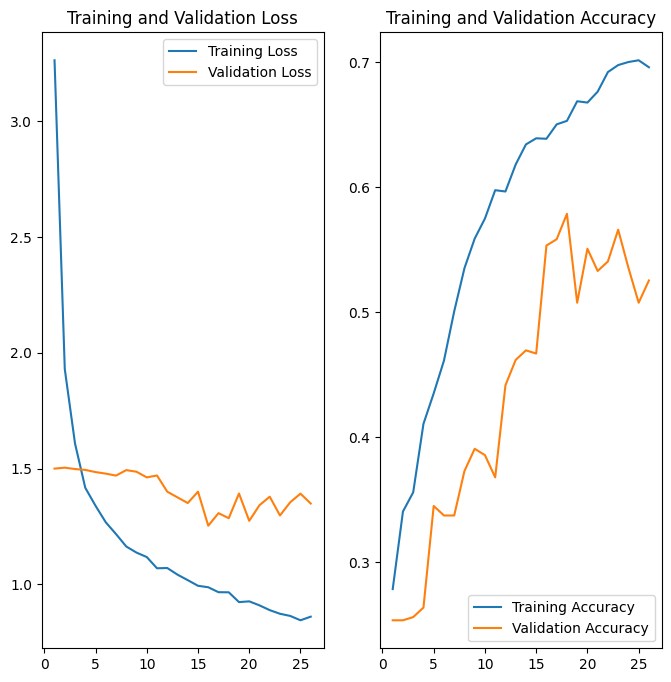

In [ ]:
# Visualization of the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = scratch_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 120ms/step - loss: 1.2535 - accuracy: 0.5533
Test loss: 1.2535213232040405
Test accuracy: 0.5532994866371155


## VGG16

VGG16 has 21 layers in total; 13 convolutional layers, five pooling layers, and three dense layers. There were only16 weighted layers among them. There are 64 filters in the first convolution layer, 128 filters in the second layer, 256 filters in the third layer, and 512 filters in each of the fourth and fifth levels. The ImageNet dataset, which contains more than 14 million images and 1,000 classifications, was used to train the VGG-16 network

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
base_model = VGG16(
    include_top=False, #rimuovo ultimo layer (ultimo layer di classificazione)
    weights='imagenet',
    classifier_activation='softmax', #This parameter determines the activation function used in the output layer (classifier)
    input_shape=(224,224,3))
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
for layer in base_model.layers:
    layer.trainable = False
#By unfreezing the BatchNormalization layers, you enable the model to adjust the normalization statistics specifically for the new dataset, which can help improve the model's performance and adaptability.
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = keras.layers.Dropout(0.5)(x)


outputs = keras.layers.Dense(4, activation="softmax")(x)
# Create the final model
VGG16_model = Model(inputs=base_model.input, outputs=outputs)
VGG16_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=5e-5),
            metrics=['accuracy'])

In [ ]:
history = VGG16_model.fit(train_generator,
          epochs=60,
          validation_data=validation_generator,
           callbacks=[callback, mcp_save])


Epoch 1/60
45/45 [==============================] - 47s 960ms/step - loss: 1.8278 - accuracy: 0.2589 - val_loss: 1.7232 - val_accuracy: 0.2081
Epoch 2/60
45/45 [==============================] - 43s 946ms/step - loss: 1.5938 - accuracy: 0.3059 - val_loss: 1.5643 - val_accuracy: 0.2284
Epoch 3/60
45/45 [==============================] - 43s 951ms/step - loss: 1.4945 - accuracy: 0.3167 - val_loss: 1.5127 - val_accuracy: 0.2970
Epoch 4/60
45/45 [==============================] - 42s 935ms/step - loss: 1.4243 - accuracy: 0.3589 - val_loss: 1.4680 - val_accuracy: 0.3122
Epoch 5/60
45/45 [==============================] - 42s 933ms/step - loss: 1.3809 - accuracy: 0.3746 - val_loss: 1.4492 - val_accuracy: 0.3274
Epoch 6/60
45/45 [==============================] - 43s 949ms/step - loss: 1.3330 - accuracy: 0.4247 - val_loss: 1.4251 - val_accuracy: 0.3325
Epoch 7/60
45/45 [==============================] - 42s 937ms/step - loss: 1.3017 - accuracy: 0.4310 - val_loss: 1.4063 - val_accuracy: 0.3553

In [ ]:
VGG16_model.load_weights(checkpoint_filepath)

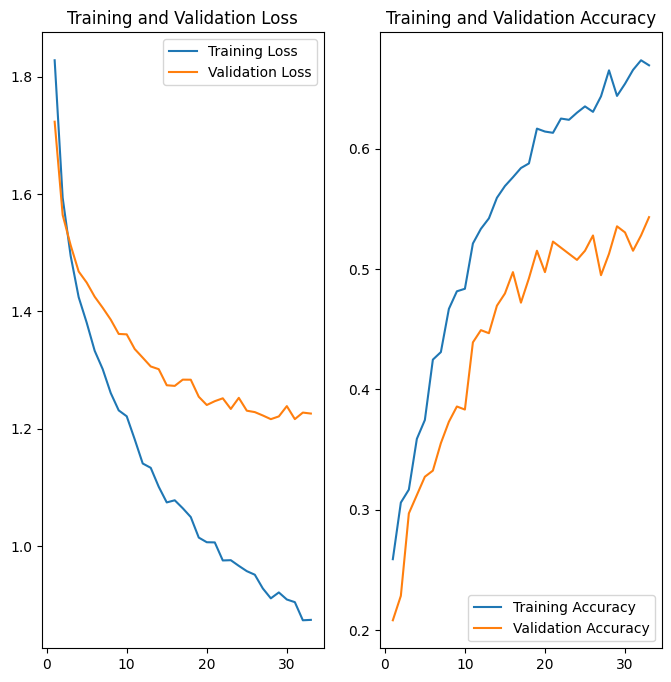

In [ ]:
# Visualization of the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = VGG16_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 153ms/step - loss: 1.2165 - accuracy: 0.5127
Test loss: 1.2165205478668213
Test accuracy: 0.5126903653144836


## VGG19

VGG-19 is a variant of the VGG model that consists of 19 layers (16 convolution layers, three fully connected layers, five MaxPool layers, and one SoftMax layer)

In [14]:
from keras.applications.vgg19 import preprocess_input

In [15]:
base_model = VGG19(
    include_top=False, #rimuovo ultimo layer (ultimo layer di classificazione)
    weights='imagenet',
    classifier_activation='softmax', #This parameter determines the activation function used in the output layer (classifier)
    input_shape=(224,224,3))
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
for layer in base_model.layers:
    layer.trainable = False
#By unfreezing the BatchNormalization layers, you enable the model to adjust the normalization statistics specifically for the new dataset, which can help improve the model's performance and adaptability.
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True



80134624/80134624 [==============================] - 5s 0us/step


In [18]:
x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(4, activation="softmax")(x)
# Create the final model
VGG19_model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model

VGG19_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=5e-5),
            metrics=['accuracy'])


In [ ]:
history = VGG19_model.fit(train_generator,
          epochs=80,
          validation_data=validation_generator,
           callbacks=[callback, mcp_save])

Epoch 1/80
90/90 [==============================] - 47s 506ms/step - loss: 2.1325 - accuracy: 0.3784 - val_loss: 2.1995 - val_accuracy: 0.3350
Epoch 2/80
90/90 [==============================] - 41s 459ms/step - loss: 1.9994 - accuracy: 0.4794 - val_loss: 2.0974 - val_accuracy: 0.4289
Epoch 3/80
90/90 [==============================] - 41s 458ms/step - loss: 1.8930 - accuracy: 0.5533 - val_loss: 2.0329 - val_accuracy: 0.4543
Epoch 4/80
90/90 [==============================] - 42s 464ms/step - loss: 1.8107 - accuracy: 0.5836 - val_loss: 1.9500 - val_accuracy: 0.4873
Epoch 5/80
90/90 [==============================] - 41s 457ms/step - loss: 1.7367 - accuracy: 0.6111 - val_loss: 1.9025 - val_accuracy: 0.5076
Epoch 6/80
90/90 [==============================] - 41s 458ms/step - loss: 1.6791 - accuracy: 0.6334 - val_loss: 1.8872 - val_accuracy: 0.5482
Epoch 7/80
90/90 [==============================] - 42s 461ms/step - loss: 1.6210 - accuracy: 0.6418 - val_loss: 1.8848 - val_accuracy: 0.5482

In [21]:
VGG19_model.load_weights(checkpoint_filepath)

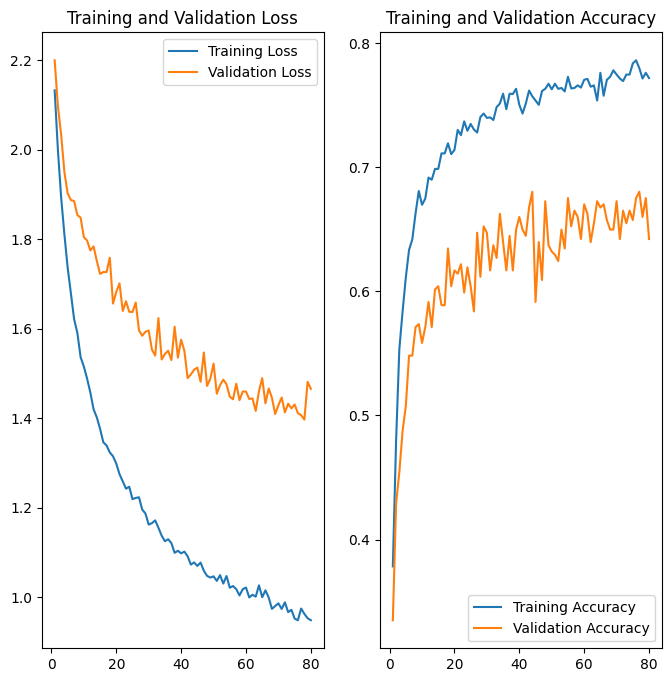

In [ ]:
epochs_range = range(1, 81)  # supponendo 80 epoche

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = VGG19_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 13s 366ms/step - loss: 2.2534 - accuracy: 0.2589
Test loss: 2.253391742706299
Test accuracy: 0.2588832378387451


While achieving interesting results, with a test accuracy of 0.6599 and a test loss of 1.3965, it is evident that overfitting persists, despite the integration of kernel regularisation, dropout and a batch size of 32.

In [ ]:
# Inference
yc_pred = VGG19_model.predict(validation_generator)
print('Prediction shape (probability distribution):', yc_pred.shape)

13/13 [==============================] - 47s 4s/step
Prediction shape (probability distribution): (394, 4)


In [ ]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

Prediction shape (argmax): (394,)


In [ ]:
# Extract true labels from the generator
y_true = validation_generator.classes
# Calculate classification report
class_names = list(validation_generator.class_indices.keys())
print("Class Names:", class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
                  precision    recall  f1-score   support

    glioma_tumor       0.59      0.47      0.53       100
meningioma_tumor       0.55      0.69      0.61       115
        no_tumor       0.78      0.71      0.75       105
 pituitary_tumor       0.78      0.80      0.79        74

        accuracy                           0.66       394
       macro avg       0.68      0.67      0.67       394
    weighted avg       0.67      0.66      0.66       394



The precision and recall values for the classes meningioma tumour, no tumour and pituitary tumour show some degree of variability, but overall demonstrate reasonable performance. However, the model recall for glioma tumours of 0.47 shows a relatively lower recall than for the other classes, indicating a need for improved detection of glioma tumours.

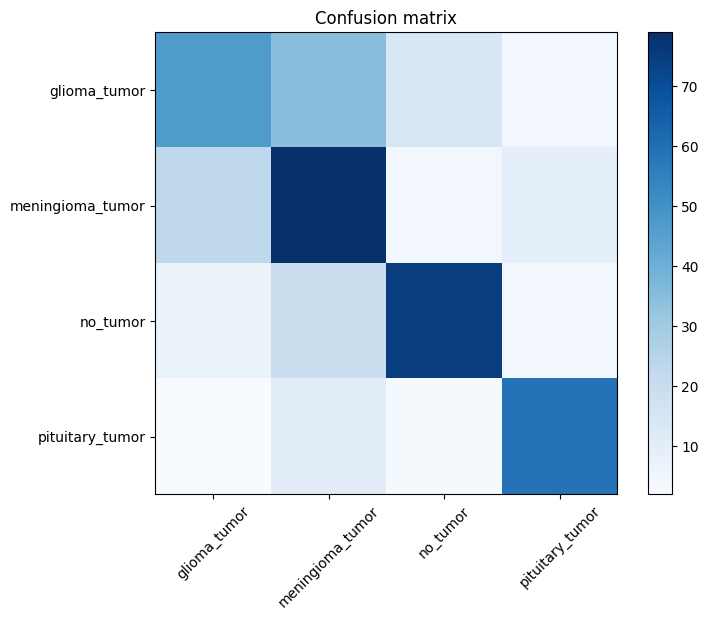

In [ ]:
# Computing the confusion matrix
cm1 = confusion_matrix(y_true, y_pred)

# Confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm1, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
for i in range(len(cm1)):
    for j in range(len(cm1[i])):
        plt.text(j, i, str(cm1[i][j]), ha='center', va='center', color='black',fontsize=12)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,fontsize=9)
plt.yticks(tick_marks, class_names,fontsize=10)
plt.show()

## ResNet50
It consists of 48 convolutional layers, one MaxPool layer, and one average pooling layer.


In [ ]:
from keras.applications.resnet50 import preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(dtype = 'float32',

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
   preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(dtype = 'float32',

    preprocessing_function=preprocess_input
)
train_generator = train_datagen.flow_from_directory(
    crop_training_path,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=64, #16 for InceptionResNetV2
    shuffle = True,
    class_mode='categorical',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    crop_testing_path,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=64,  #16 for InceptionResNetV2
    shuffle =False,
    class_mode='categorical',
    seed=42
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(
    include_top=False, #rimuovo ultimo layer (ultimo layer di classificazione)
    weights='imagenet',
    classifier_activation='softmax', #This parameter determines the activation function used in the output layer (classifier)
    input_shape=(300,300,3))
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
for layer in base_model.layers:
    layer.trainable = False
#By unfreezing the BatchNormalization layers, you enable the model to adjust the normalization statistics specifically for the new dataset, which can help improve the model's performance and adaptability.
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.00001))(x)
x = keras.layers.Dropout(0.5)(x)



outputs = keras.layers.Dense(4, activation="softmax")(x)
# Create the final model
ResNet50_model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model

ResNet50_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=5e-5),
            metrics=['accuracy'])


In [ ]:
history = ResNet50_model.fit(train_generator,
          epochs=60,
          validation_data=validation_generator,
           callbacks=[callback, mcp_save])

Epoch 1/60
90/90 [==============================] - 86s 756ms/step - loss: 6.0538 - accuracy: 0.3617 - val_loss: 2.9689 - val_accuracy: 0.3350
Epoch 2/60
90/90 [==============================] - 67s 746ms/step - loss: 1.7651 - accuracy: 0.5192 - val_loss: 1.8854 - val_accuracy: 0.4315
Epoch 3/60
90/90 [==============================] - 86s 960ms/step - loss: 1.2500 - accuracy: 0.5436 - val_loss: 1.5264 - val_accuracy: 0.4365
Epoch 4/60
90/90 [==============================] - 86s 955ms/step - loss: 1.1007 - accuracy: 0.5582 - val_loss: 1.3679 - val_accuracy: 0.4543
Epoch 5/60
90/90 [==============================] - 85s 944ms/step - loss: 1.0495 - accuracy: 0.5847 - val_loss: 1.3618 - val_accuracy: 0.4442
Epoch 6/60
90/90 [==============================] - 85s 946ms/step - loss: 0.9811 - accuracy: 0.5997 - val_loss: 1.2805 - val_accuracy: 0.5000
Epoch 7/60
90/90 [==============================] - 67s 740ms/step - loss: 0.9415 - accuracy: 0.6143 - val_loss: 1.4080 - val_accuracy: 0.4670

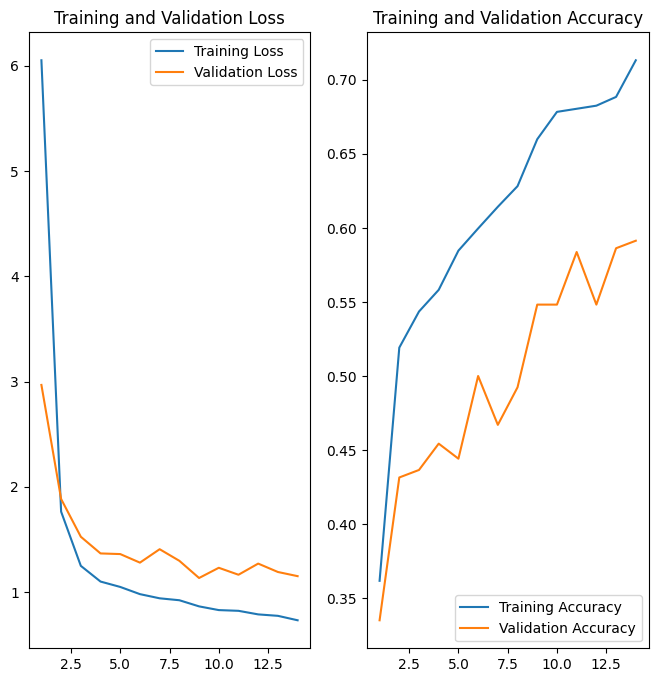

In [ ]:
# Visualization of the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
ResNet50_model.load_weights(checkpoint_filepath)

In [ ]:
# Evaluation Best Model
score = ResNet50_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 3s 152ms/step - loss: 1.3287 - accuracy: 0.5431
Test loss: 1.3287321329116821
Test accuracy: 0.5431472063064575


In [ ]:
# Inference
yc_pred = ResNet50_model.predict(validation_generator)
print('Prediction shape (probability distribution):', yc_pred.shape)
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

7/7 [==============================] - 2s 155ms/step
Prediction shape (probability distribution): (394, 4)
Prediction shape (argmax): (394,)


In [ ]:
# Extract true labels from the generator
y_true = validation_generator.classes
# Calculate classification report
class_names = list(validation_generator.class_indices.keys())
print("Class Names:", class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
                  precision    recall  f1-score   support

    glioma_tumor       0.55      0.30      0.39       100
meningioma_tumor       0.50      0.48      0.49       115
        no_tumor       0.60      0.76      0.67       105
 pituitary_tumor       0.52      0.66      0.58        74

        accuracy                           0.54       394
       macro avg       0.54      0.55      0.53       394
    weighted avg       0.54      0.54      0.53       394



## InceptionResNetV2

It has  572 layers

In [ ]:
from keras.applications.resnet50 import preprocess_input

In [ ]:
base_model = InceptionResNetV2(
    include_top=False, #rimuovo ultimo layer (ultimo layer di classificazione)
    weights='imagenet',
    classifier_activation='softmax', #This parameter determines the activation function used in the output layer (classifier)
    input_shape=(224,224,3))
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
for layer in base_model.layers:
    layer.trainable = False
#By unfreezing the BatchNormalization layers, you enable the model to adjust the normalization statistics specifically for the new dataset, which can help improve the model's performance and adaptability.
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.00001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)



outputs = keras.layers.Dense(4, activation="softmax")(x)
# Create the final model
InceptionResNetV2_model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model

InceptionResNetV2_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=5e-6),
            metrics=['accuracy'])

In [ ]:
history = InceptionResNetV2_model.fit(train_generator,
          epochs=60,
          validation_data=validation_generator,
           callbacks=[callback, mcp_save])

Epoch 1/60
180/180 [==============================] - 92s 255ms/step - loss: 1.9943 - accuracy: 0.3272 - val_loss: 1.4426 - val_accuracy: 0.3782
Epoch 2/60
180/180 [==============================] - 40s 224ms/step - loss: 1.5880 - accuracy: 0.4359 - val_loss: 1.4630 - val_accuracy: 0.4594
Epoch 3/60
180/180 [==============================] - 40s 224ms/step - loss: 1.4537 - accuracy: 0.4780 - val_loss: 1.3957 - val_accuracy: 0.4924
Epoch 4/60
180/180 [==============================] - 41s 225ms/step - loss: 1.3476 - accuracy: 0.5206 - val_loss: 1.4248 - val_accuracy: 0.4645
Epoch 5/60
180/180 [==============================] - 41s 227ms/step - loss: 1.2256 - accuracy: 0.5401 - val_loss: 1.4741 - val_accuracy: 0.4848
Epoch 6/60
180/180 [==============================] - 41s 225ms/step - loss: 1.1953 - accuracy: 0.5620 - val_loss: 1.3492 - val_accuracy: 0.5381
Epoch 7/60
180/180 [==============================] - 40s 222ms/step - loss: 1.1495 - accuracy: 0.5833 - val_loss: 1.2945 - val_ac

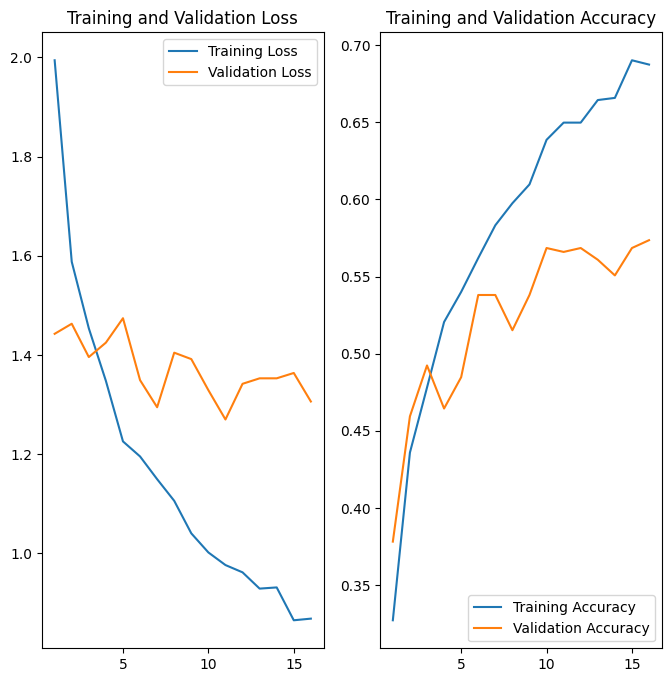

In [ ]:
# Visualization of the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = InceptionResNetV2_model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 [==============================] - 1s 43ms/step - loss: 1.3061 - accuracy: 0.5736
Test loss: 1.306098222732544
Test accuracy: 0.5736040472984314


# Inference

In [22]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array

In [26]:
path_inference= '/content/gdrive/MyDrive/digital signal and image management progetto/bi_dim_signal - Doghmi Samir/brain_jpg.zip'
# Import and extract training dataset
base_path_training = import_and_extract_dataset(path_inference, 'brain_jpg.zip')
print("Base path for training dataset:", base_path_training)


File transfer completed in 0.008 seconds
Base path for training dataset: brain_jpg.zip


In [27]:
inference_folder= '/content/brain_jpg'

1/1 [==============================] - 0s 17ms/step


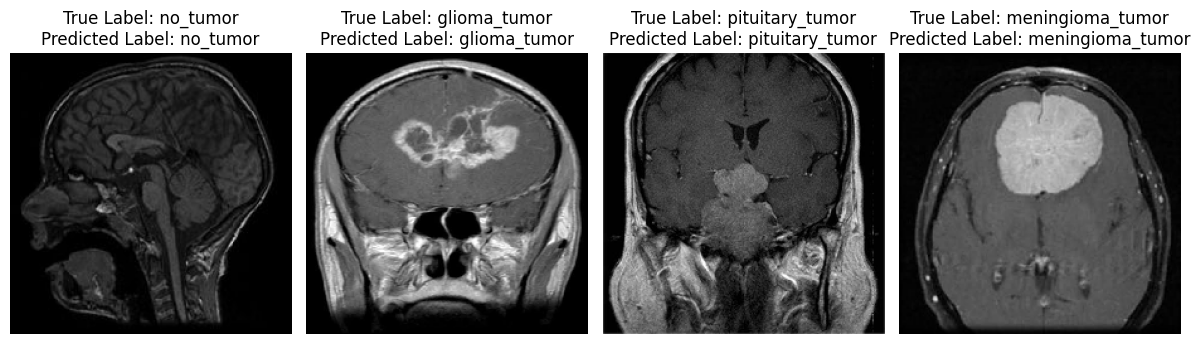

In [28]:
label_map = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "no_tumor",
    3: "pituitary_tumor"
}
image_names = os.listdir(inference_folder)
image_paths = [os.path.join(inference_folder, name) for name in image_names if name.endswith('.jpg')]

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for idx, img_path in enumerate(image_paths):
    true_label = os.path.splitext(os.path.basename(img_path))[0]
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = VGG19_model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = label_map[predicted_class]

    axes[idx].imshow(img)
    axes[idx].set_title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()